# Classic DPP

## 1. Classic DPP

In [1]:
import numpy as np
from numpy.matlib import repmat
import plotly.graph_objs as go
import plotly.offline
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline

In [2]:
def herm_matrix(dim, beta): #beta=1 pour real et 2 pour herm
    B = np.random.randn(dim, dim)
    B_tild = np.random.randn(dim, dim)
    diag = (2/(beta*dim))**0.5 * np.diag(np.diag(B))
    triu = (1/(beta*dim))**0.5 * (np.triu(B,1) + 1j*(beta-1)*np.triu(B_tild,1))
    H = np.zeros((dim,dim)) + diag + triu + triu.T
    return H

In [3]:
class DPP:
    def __init__(self, n_traj, n_samples, tf, rescaling=False):
        self.n_traj = n_traj
        self.n_samples = n_samples
        self.tf = tf
        self.dt = tf/n_samples
        #self.dpp_matrix = np.zeros((self.n_samples, self.n_traj, self.n_traj))
        self.dpp_matrix = [np.zeros((self.n_traj, self.n_traj))]
        self.generate()
        self.eigen_values = np.zeros((self.n_samples, self.n_traj))
        self.diag(rescaling)

    def generate(self):
        for sample in range(self.n_samples-1):
            self.dpp_matrix.append(self.dpp_matrix[sample] + \
                herm_matrix(self.n_traj, beta=2)*(self.dt)**0.5)

    def diag(self, rescaling):
        if rescaling:
            for sample in range(self.n_samples-1):
                eigen_values = \
                    sorted(np.real(np.linalg.eigvals(self.dpp_matrix[sample+1])), reverse=True)
                self.eigen_values[sample+1] = np.multiply(eigen_values, 1/np.sqrt((sample+1)*self.dt))
                #print(1/np.sqrt((sample+1)*self.dt))
        else:
            for sample in range(self.n_samples-1):
                self.eigen_values[sample+1] = \
                    sorted(np.real(np.linalg.eigvals(self.dpp_matrix[sample+1])), reverse=True)

    def plot(self):
        data=[]
        for traj in range(self.n_traj):
            traj_trace = go.Scatter(
                x=self.dt*np.array(range(self.n_samples)),
                y=(self.eigen_values.T)[traj],
                mode='lines')
            data.append(traj_trace)
        layout = go.Layout(showlegend=False)
        fig = go.Figure(data=data, layout=layout)
        plotly.offline.init_notebook_mode()
        plotly.offline.iplot(fig)


In [4]:
test_classic_dpp = DPP(50, 100, 1)
test_classic_dpp.plot()

In [5]:
herm_matrix(4, beta=1)

array([[-0.11752525+0.j, -0.67559997+0.j,  0.12614578+0.j,  0.32242386+0.j],
       [-0.67559997+0.j, -0.47067145+0.j, -0.47175868+0.j,  0.86836408+0.j],
       [ 0.12614578+0.j, -0.47175868+0.j,  0.14504720+0.j,  0.01836126+0.j],
       [ 0.32242386+0.j,  0.86836408+0.j,  0.01836126+0.j, -0.21231481+0.j]])

## 2. Rescaling

In [6]:
test_classic_dpp_rescale = DPP(100, 100, 1, rescaling=True)
test_classic_dpp_rescale.plot()

With the semi-circular law

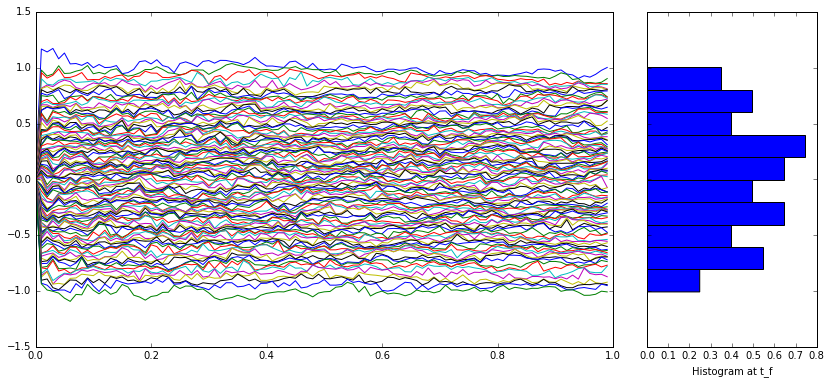

In [7]:
fig = plt.figure(1, figsize=(14, 6))
gs = GridSpec(1,4)

dpp_fig = fig.add_subplot(gs[0,0:3])
dpp_hist = fig.add_subplot(gs[0,3])

t = np.matlib.repmat(np.arange(0, test_classic_dpp_rescale.tf, test_classic_dpp_rescale.dt),test_classic_dpp_rescale.n_traj,1)
dpp_fig.plot(t.T, test_classic_dpp_rescale.eigen_values)

dpp_hist.hist(test_classic_dpp_rescale.eigen_values[-1], bins=10, normed=True, orientation='horizontal')

plt.setp(dpp_hist.get_yticklabels(), visible=False)
dpp_hist.set_xlabel('Histogram at t_f')
dpp_hist.set_ylim(dpp_fig.get_ylim())
plt.show()